In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchaudio transformers librosa pandas numpy scikit-learn matplotlib seaborn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from transformers import Wav2Vec2FeatureExtractor, HubertModel

# Enable GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load HuBERT Model
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [ ]:
import os
import torchaudio

# Set path to folder containing audio files
DATASET_PATH = "/content/drive/MyDrive/Crema"

# Get list of all audio files
audio_files = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.endswith('.wav')]

# Display first few files
audio_files[:5]


['/content/drive/MyDrive/Crema/1079_IWW_HAP_XX.wav',
 '/content/drive/MyDrive/Crema/1079_TAI_NEU_XX.wav',
 '/content/drive/MyDrive/Crema/1079_TAI_FEA_XX.wav',
 '/content/drive/MyDrive/Crema/1079_TSI_ANG_XX.wav',
 '/content/drive/MyDrive/Crema/1079_TSI_DIS_XX.wav']

In [ ]:
import pandas as pd

# Extract labels
def extract_emotion(filename):
    return filename.split('_')[2]  # Assuming emotion is the first part of filename

# Create DataFrame
metadata = pd.DataFrame({"File_Path": audio_files,
                         "Emotion": [extract_emotion(os.path.basename(f)) for f in audio_files]})

# Display extracted labels
print(metadata.head())


                                          File_Path Emotion
0  /content/drive/MyDrive/Crema/1079_IWW_HAP_XX.wav     HAP
1  /content/drive/MyDrive/Crema/1079_TAI_NEU_XX.wav     NEU
2  /content/drive/MyDrive/Crema/1079_TAI_FEA_XX.wav     FEA
3  /content/drive/MyDrive/Crema/1079_TSI_ANG_XX.wav     ANG
4  /content/drive/MyDrive/Crema/1079_TSI_DIS_XX.wav     DIS


In [ ]:
metadata.count()

,0
File_Path,7462
Emotion,7462
Features,7462
Emotion_Label,7462


In [ ]:
import numpy as np

# Function to preprocess audio (Convert to mono & resample to 16kHz)
def preprocess_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    waveform = waveform.mean(dim=0)  # Convert stereo to mono
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    return waveform

# Function to extract HuBERT embeddings in batches
def extract_features_batch(file_paths):
    waveforms = [preprocess_audio(f).numpy() for f in file_paths]

    # Convert to tensor and move to GPU
    inputs = feature_extractor(waveforms, sampling_rate=16000, return_tensors="pt", padding=True).input_values
    inputs = torch.tensor(inputs).to(device)

    # Extract embeddings
    with torch.no_grad():
        outputs = hubert_model(inputs).last_hidden_state

    return outputs.mean(dim=1).cpu().numpy()  # Mean pooling

# Process in batches (e.g., 100 files at a time)
batch_size = 100
feature_list = []

for i in range(0, len(metadata), batch_size):
    batch_files = metadata['File_Path'][i:i+batch_size].tolist()
    batch_features = extract_features_batch(batch_files)
    feature_list.extend(batch_features)

# Add features to DataFrame
metadata["Features"] = feature_list


<ipython-input-8-e283ab307784>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Encode emotions
le = LabelEncoder()
metadata['Emotion_Label'] = le.fit_transform(metadata['Emotion'])

# Prepare dataset
X = np.stack(metadata['Features'].values)
y = metadata['Emotion_Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.550569323509712
              precision    recall  f1-score   support

         ANG       0.65      0.77      0.71       254
         DIS       0.50      0.45      0.48       255
         FEA       0.53      0.31      0.39       255
         HAP       0.52      0.54      0.53       256
         NEU       0.60      0.60      0.60       218
         SAD       0.50      0.63      0.56       255

    accuracy                           0.55      1493
   macro avg       0.55      0.55      0.54      1493
weighted avg       0.55      0.55      0.54      1493



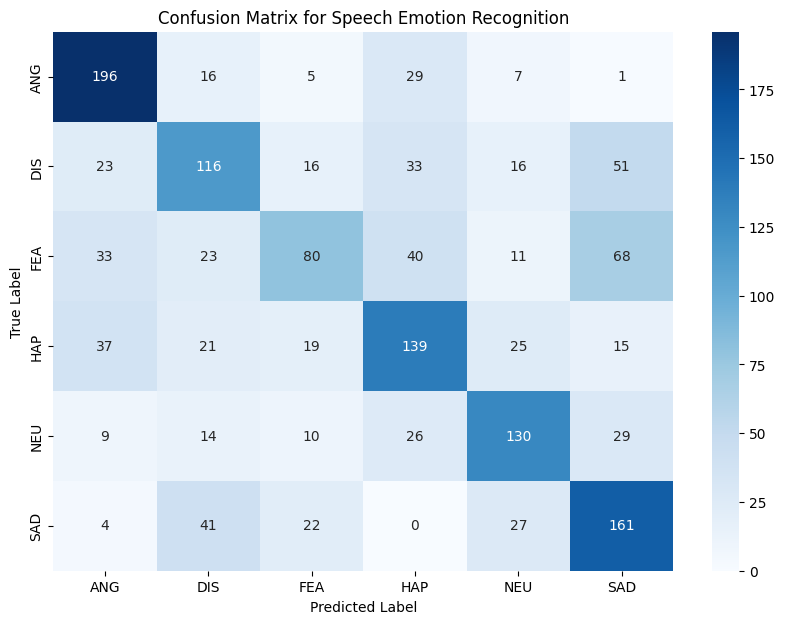

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Speech Emotion Recognition")
plt.show()
